gonna test synchronization again

We import the usual packages. **xgboost** needs to be installed (with conda install xgboost or pip install -U xgboost).

In [6]:
#!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/96/84/4e2cae6247f397f83d8adc5c2a2a0c5d7d790a14a4c7400ff6574586f589/xgboost-0.90.tar.gz
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /Users/jjaskolkambp/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [82]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from collections import Counter
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import sys
import random as rn
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from torchnlp.datasets import imdb_dataset
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We already have the bert server running somewhere, so we are just starting a client.

In [4]:
#clin = pd.read_csv('500_cleaned.csv', parse_dates=['Triage Date & Time','Reg Date & Time', 'PIA Date & Time', 'Disposition Date & Time', 'Left ED Date & Time'])
clin = pd.read_excel('jj_modified_bch_data.xlsx', nrows = 10000)

In [5]:
len(clin)

10000

In [131]:
clin.head()

,ID,ChartNumber,EncounterNumber,TriageLevel,AgeNumber,AgeInYrs,GenderDesc,Triage Date & Time,Reg Date & Time,PIA Date & Time,...,Are you feeling feverish or have had shakes or chills in the last 24 hours?,Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?,Do you have a new Rash?,Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?,Have you travelled outside of Canada/USA in the last 3 weeks?,Have you had contact with a sick person who has travelled outside of Canada/USA in the last 3 weeks?,Have you received Health Care in another country in the last 2 years?,Do you have a new/worse cough or shortness of breath?,"If so, select all countries that apply","If so, select all infectious diseases that apply"
0,1,N675533,NE000001/18,3.0,12,12.0,Male,31/03/2018 11:55:00PM,01/04/2018 12:03:00AM,01/04/2018 1:36:00AM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,N798153,NE000002/18,2.0,80,80.0,Female,31/03/2018 11:22:00PM,01/04/2018 12:08:00AM,01/04/2018 1:10:00AM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,N783129,NE000003/18,3.0,3,3.0,Male,01/04/2018 12:01:00AM,01/04/2018 12:10:00AM,01/04/2018 1:49:00AM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,N299709,NE000004/18,3.0,56,56.0,Female,01/04/2018 12:04:00AM,01/04/2018 12:13:00AM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,N17059,NE000005/18,2.0,69,69.0,Female,01/04/2018 12:11:00AM,01/04/2018 12:14:00AM,01/04/2018 1:40:00AM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
clin.dropna(subset = ['SubjectiveNotes'], inplace = True)

In [7]:
len(clin)

7582

In [8]:
o2sat = [item if item[-1] != '%' else item[:-1] for item in clin['O2Saturation_LastEDReading'].astype('str')]
o2sat = [np.nan if item == 'nan' else float(item) for item in o2sat] 
clin['o2sat'] = o2sat

In [11]:
pulse = clin['Pulse_LastEDReading']
pulse = [re.sub("[^0-9]", "", str(item)) for item in pulse]
pulse = [np.nan if item == '' else float(item) for item in pulse] 
#set(pulse)
clin['pulse'] = pulse

In [12]:
temp = clin['Temperature_LastEDReading']
temp = [re.sub("[^0-9]", "", str(item)) for item in temp]
temp = [np.nan if item == '' else float(item) for item in temp] 
temp = [item/10 if item > 100 else item for item in temp]
temp = [np.nan if item > 40  else item for item in temp]
#set(temp)
clin['temp'] = temp

In [13]:
clin.columns

Index(['ID', 'ChartNumber', 'EncounterNumber', 'TriageLevel', 'AgeNumber',
       'AgeInYrs', 'GenderDesc', 'Triage Date & Time', 'Reg Date & Time',
       'PIA Date & Time', 'Disposition Date & Time', 'DischargeDisposition',
       'DischargeDispositionDesc', 'Left ED Date & Time',
       'PresentingComplaint', 'PresentingComplaintDesc', 'MainDiagnosisCode',
       'MainDiagnosisCodeDesc', 'AdmitLocation', 'PatientService',
       'SubjectiveNotes', 'InfectionControlScreening', 'MedicalHistory',
       'BloodPressure_LastEDReading', 'O2Saturation_LastEDReading',
       'Pulse_LastEDReading', 'Temperature_LastEDReading',
       'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
       'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
       'Do you have a new Rash?',
       'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
       'Have you travelled outside of Canada/U

In [14]:
count = Counter(clin['AdmitLocation']); count

Counter({nan: 6800,
         'N.SUR ORTH': 15,
         'N.MH CHADI': 11,
         'N.SUR SS': 38,
         'N.MH CHAD': 10,
         'N.MED CARD': 83,
         'N.MAU': 128,
         'N.MED ONC': 40,
         'N.MED GER': 34,
         'N.CC ICU': 12,
         'N.SIMCU': 8,
         'N.MH INTEN': 21,
         'N.SUR GEN': 64,
         'N.WC PAED': 67,
         'N.MED NEUR': 44,
         'N.MED CT': 27,
         'N.CC CCU': 22,
         'N.ER IN': 40,
         'N.MH GER': 1,
         'N.MED RESP': 29,
         'N.MED SIM': 23,
         'N.MH GENC': 7,
         'N.MH GENB': 9,
         'N.MED SIX': 28,
         'N.MED DIAL': 5,
         'N.MED CPU': 10,
         'N.ERMH IN': 2,
         'N.WC POST': 4})

gonna collapse all the dispositions into 1 of 4 types - d/c, admit med, admit surg, icu

In [15]:
clin['outcome'] = clin['AdmitLocation'].astype('str').map(
{'N.CC CCU': 'ICU',
 'N.CC ICU': 'ICU',
 'N.ER IN' : 'madmit',
 'N.ERMH IN': 'madmit',
 'N.MAU': 'madmit',
 'N.MED CARD': 'madmit',
 'N.MED CPU': 'madmit',
 'N.MED CT': 'madmit',
 'N.MED GER': 'madmit',
 'N.MED DIAL': 'madmit',
 'N.MED NEUR': 'madmit',
 'N.MED ONC': 'madmit',
 'N.MED RESP': 'madmit',
 'N.MED SIM': 'madmit',
 'N.MED SIX': 'madmit',
 'N.MH CHAD': 'madmit',
 'N.MH CHADI': 'madmit',
 'N.MH GENB': 'madmit',
 'N.MH GER': 'madmit',
 'N.MH INTEN': 'madmit',
 'N.SIMCU': 'ICU',
 'N.SUR GEN': 'sadmit',
 'N.SUR ORTH': 'sadmit',
 'N.SUR SS': 'sadmit',
 'N.WC PAED': 'madmit',
 'N.WC POST': 'madmit',
 'N.MH GENC': 'madmit',
 'N.CC NICU': 'ICU',
 'nan': 'discharge'})

In [16]:
from collections import Counter
count = Counter(clin['outcome']); count

Counter({'discharge': 6800, 'sadmit': 117, 'madmit': 623, 'ICU': 42})

gonna make a new column mapping dispositions to numbers

In [69]:
clin['target'] = clin['outcome'].map({'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4})

In [70]:
clin['discharge'] = clin['outcome'].map({'discharge': 1, 'madmit': 0, 'sadmit': 0, 'ICU': 0})

In [71]:
clin['dispo']= clin['outcome'].map({'discharge': np.nan, 'madmit': 1, 'sadmit': 2, 'ICU': 3})

In [18]:
count = Counter(clin['target']); count

Counter({1: 6800, 3: 117, 2: 623, 4: 42})

**bptrans** parses the blood pressure column into systolic and diastolic, **fixencode** does some preprocessing on text and then feeds it to the bert server.


JJ couldn't install bert server so I'm doing the bert stuff manually

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [20]:
def bptrans(bp):
    if pd.isnull(bp):
        return [np.nan, np.nan]
    res = []
    for x in bp.split('/'):
        try:
            float(x)
            res =  [float(x) for x in bp.split('/')]
        except: 
            res =  [np.nan, np.nan]
        return res

def fixencode(s):
    if pd.isnull(s):
        s = "None"
    s=s.replace('<LT><LF>',',')
    s=s.replace('Pt.', 'patient')
    s=s.replace('Pt', 'patient')
    s= s.replace('pt.', 'patient')
    s=s.replace('pt', 'patient')
    s = s.replace('y/o', 'year old')
    return tokenizer.tokenize(s.split("=")[-1:])

below is my function to replace the fixencode function that I can't use

In [21]:
def fix(s):
    if pd.isnull(s):
        s = "None"
    s=s.replace('<LT><LF>',',')
    s=s.replace('Pt.', 'patient')
    s=s.replace('Pt', 'patient')
    s= s.replace('pt.', 'patient')
    s=s.replace('pt', 'patient')
    s = s.replace('y/o', 'year old')
    s = s.replace('c/o', 'complains of')
    s = s.replace('C/o', 'complains of')
    return s

In [22]:
clin['BP'] = clin.BloodPressure_LastEDReading.map(bptrans)
clin[['systolic', 'diastolic']] = pd.DataFrame(clin.BP.tolist(), index= clin.index)
clin["Gender"] = clin.GenderDesc.map(lambda x: 1 if x == "Male" else 0)

In [143]:
clin.drop(['BloodPressure_LastEDReading', 'BP'], axis=1, inplace=True)
clin.drop(['AdmitLocation', 'PatientService'], axis=1, inplace=True)

In [23]:
clin.columns

Index(['ID', 'ChartNumber', 'EncounterNumber', 'TriageLevel', 'AgeNumber',
       'AgeInYrs', 'GenderDesc', 'Triage Date & Time', 'Reg Date & Time',
       'PIA Date & Time', 'Disposition Date & Time', 'DischargeDisposition',
       'DischargeDispositionDesc', 'Left ED Date & Time',
       'PresentingComplaint', 'PresentingComplaintDesc', 'MainDiagnosisCode',
       'MainDiagnosisCodeDesc', 'AdmitLocation', 'PatientService',
       'SubjectiveNotes', 'InfectionControlScreening', 'MedicalHistory',
       'BloodPressure_LastEDReading', 'O2Saturation_LastEDReading',
       'Pulse_LastEDReading', 'Temperature_LastEDReading',
       'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
       'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
       'Do you have a new Rash?',
       'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
       'Have you travelled outside of Canada/U

I couldn't use the bert as sevice code because I didn't have bert as service so I do the conversion manually below

In [25]:
clin['SubjectiveNotes'] = clin['SubjectiveNotes'].str[14:]

In [26]:
#this cell applies the fixes from above and makes a new column with cleaner notes
#then I make the column into a list so I can process with BERT

clin['notes'] = clin.SubjectiveNotes.map(fix)
notes = list(clin['notes'])

In [27]:
#comparing original to processed
print (clin['SubjectiveNotes'].iloc[0])
print ()
print (notes[0])

pt states that she feels shaky.  pt denies any pain.

patient states that she feels shaky.  patient denies any pain.


In [ ]:
#from bert tutorial notebook
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
#train texts is a tuple of 1000 strings, each of which is review

train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
#list of 1000 reviews each turned into a list of tokens by BERT

train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
#list of 1000 reviews turned into numbers and padded to length 512


In [57]:
#had to do this a second time because of a change in the axes later
notes = list(clin['notes'])

In [58]:
#assign the notes list to be the same as train_texts so I can follow the above cell for guidance
train_texts = notes; len(train_texts)

6691

In [108]:
train_labels1 = list(clin['target'])
train_labels2 = list(clin['discharge'])

In [110]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]

In [59]:
#train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(str(t))[:510] + ['[SEP]'], train_texts))
train_tokens = list(map(lambda t: tokenizer.tokenize(str(t)), train_texts))

In [60]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

In [61]:
train_tokens_ids[0]

array([ 5776,  2163,  2008,  2016,  5683, 15311,  1012,  5776, 23439,
        2151,  3255,  1012,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [112]:
model = BertModel.from_pretrained('bert-base-uncased')

In [121]:
x = torch.tensor(train_tokens_ids[:3])
m = torch.tensor(train_masks[:3])

In [123]:
y , pooled = model(x.long(),m.long(), output_all_encoded_layers=False)

In [126]:
pooled[0]

tensor([ 6.5504e-01,  8.6657e-02, -9.7582e-02,  6.2457e-02,  4.0925e-01,
         1.7259e-01, -8.6009e-01, -2.8723e-02, -4.8994e-01,  9.4875e-01,
        -5.8114e-03, -5.3294e-02,  2.0680e-02, -1.1287e-01, -1.1511e-01,
         8.0709e-01,  7.5260e-01,  1.8123e-01,  1.9378e-01,  9.5610e-01,
         3.1497e-01,  9.4671e-01, -1.1798e-01,  1.3673e-01,  1.4314e-01,
         3.8926e-02, -1.0168e-01,  4.7396e-01, -5.1728e-02,  2.5480e-01,
         3.4469e-01, -2.5364e-01, -7.3277e-01, -3.0207e-02, -9.0162e-01,
         3.0443e-01, -7.6836e-02,  3.8794e-01,  1.5638e-01,  3.9941e-01,
        -2.2974e-01, -3.7116e-01, -2.4921e-01,  7.6662e-01,  6.6662e-01,
         2.7468e-01,  9.9542e-01,  1.6939e-01,  2.2667e-01,  3.8433e-01,
         1.9357e-01,  8.4833e-01, -3.3140e-01, -1.8570e-01, -1.0498e-01,
        -3.9703e-01, -7.8655e-02, -3.8133e-02,  3.5483e-01,  2.0850e-01,
        -6.3281e-02,  1.0864e-01, -6.3767e-01,  4.0465e-01, -1.7243e-01,
         6.3644e-02, -5.2243e-02, -1.6365e-02,  3.5

In [35]:
clin.dropna(subset = 
           ['systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs', 'Gender'],
           inplace = True)

In [62]:
len(clin)

6691

First, we don't use ANY NLP stuff.

In [37]:
features = clin[['systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs', 'Gender']]

In [72]:
target = clin['discharge']
target3 = clin['target']  #added by JJ

In [73]:
#X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [74]:
xgc = xgb.XGBClassifier()

In [75]:
%time xgc.fit(X_train, y_train)

CPU times: user 4.63 s, sys: 29.1 ms, total: 4.66 s
Wall time: 4.7 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [76]:
preds = xgc.predict(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [77]:
y_test.value_counts()

1    1516
0     157
Name: discharge, dtype: int64

In [84]:
conf = confusion_matrix(y_test, preds); conf

array([[   8,  149],
       [   9, 1507]])

In [90]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds)
rec = sklearn.metrics.recall_score(y_test,preds)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8696494565162537
f1:           [0.09195402 0.95018916]
accuracy:     0.9055588762701734
precision:    0.910024154589372
recall:       0.9940633245382586


In [86]:
lab_count = Counter(clin['discharge']); lab_count

Counter({1: 6006, 0: 685})

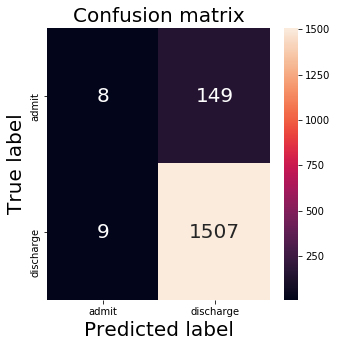

In [88]:
LABELS = ['admit', 'discharge'] #lab_count.keys()

plt.figure(figsize=(5, 5))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

now we are going to repeat the process with JJ's 4 class target

In [91]:
X_train, X_test, y_train, y_test = train_test_split(features, target3, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[1512,    4,    0,    0],
       [ 108,    6,    0,    0],
       [  36,    1,    0,    0],
       [   6,    0,    0,    0]])

In [106]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average = None)
rec = sklearn.metrics.recall_score(y_test,preds, average = None)
print ('weighted f1:        ',f1_w)
print ('f1:                 ',f1)
print ('accuracy:    {0:.2f}%'.format(100*acc))
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:         0.8687874745570356
f1:                  [0.95154185 0.096      0.         0.        ]
accuracy:    90.74%
precision:    [0.90974729 0.54545455 0.         0.        ]
recall:       [0.99736148 0.05263158 0.         0.        ]


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


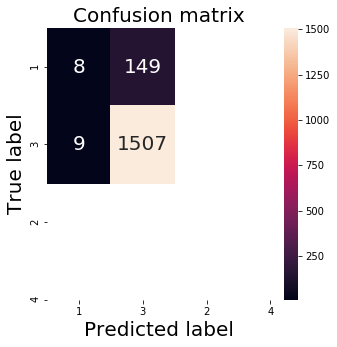

In [107]:
LABELS = Counter(clin['target']).keys()

plt.figure(figsize=(5, 5))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

Now, we want to use bert encodings. The problem is that these are very wide, so if we used the whole array (just for clinical notes) we would have 500 rows each of length over 1000, which is a recipe for disaster. So, let's try to (a) use just clinical notes, and (b) reduce dimension for using TSNE (a nonlinear dimension reducer). It reduces dimension to 2 (which is very low indeed).

In [182]:
tsner = TSNE()

In [ ]:
berttsne = tsner.fit_transform(train_tokens_ids)

In [46]:
tsnedf = pd.DataFrame(berttsne, index = clin.index)

In [47]:
features = pd.concat([clin[['systolic', 'diastolic', 'Pulse_LastEDReading', 'O2Saturation_LastEDReading', 'Temperature_LastEDReading', 'AgeInYrs', 'Gender']], tsnedf], axis=1)

In [48]:
xgc = xgb.XGBClassifier()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [50]:
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)

In [51]:
confusion_matrix(y_test, preds)

array([[ 0,  2,  0,  0,  0],
       [ 0, 16, 23,  1,  0],
       [ 0, 12, 57,  3,  0],
       [ 0,  2,  8,  0,  0],
       [ 0,  0,  2,  0,  0]])

We get essentially the same results as before for triage level. What about disposition?

In [52]:
xgc = xgb.XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split(features, target2, random_state=1)

In [53]:
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

array([[  3,   0,   4,   0,   0],
       [  0,   1,   1,   0,   0],
       [  1,   1, 112,   0,   0],
       [  0,   0,   1,   0,   0],
       [  0,   0,   2,   0,   0]])

We notice that the accuracy is the same, and the results are similar. Let us try a linear but higher-dimensional reduction.

In [54]:
pcaer = PCA(n_components=30)

In [55]:
bertpca = pcaer.fit_transform(bertnotes, None)

In [56]:
pcadf = pd.DataFrame(bertpca, index=clin.index)

In [57]:
features = pd.concat([clin[['systolic', 'diastolic', 'Pulse_LastEDReading', 'O2Saturation_LastEDReading', 'Temperature_LastEDReading', 'AgeInYrs', 'Gender']], pcadf], axis=1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

array([[ 0,  2,  0,  0,  0],
       [ 0,  9, 31,  0,  0],
       [ 0,  9, 63,  0,  0],
       [ 0,  0, 10,  0,  0],
       [ 0,  0,  2,  0,  0]])

We get worse results for triage level. What about disposition?

In [59]:
X_train, X_test, y_train, y_test = train_test_split(features, target2, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

array([[  2,   0,   5,   0,   0],
       [  0,   1,   1,   0,   0],
       [  2,   0, 112,   0,   0],
       [  0,   0,   1,   0,   0],
       [  0,   0,   2,   0,   0]])

Clearly worse results.

For kicks, let us try NOT reducing dimension.

In [63]:
bertdf = pd.DataFrame(train_tokens_ids, index=clin.index)

In [64]:
features = pd.concat([clin[['systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs', 'Gender']], bertdf], axis=1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 78, 415,   0,   0],
       [ 53, 815,   0,   0],
       [  7, 211,   0,   0],
       [  3,  91,   0,   0]])

We do get noticeably better results (77/126 = 61%).

In [136]:
X_train, X_test, y_train, y_test = train_test_split(features, target2, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[  2,   0,   5,   0,   0],
       [  0,   0,   2,   0,   0],
       [  0,   0, 114,   0,   0],
       [  0,   0,   1,   0,   0],
       [  0,   0,   2,   0,   0]])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(features, target3, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[1512,    4,    0,    0],
       [ 108,    6,    0,    0],
       [  36,    1,    0,    0],
       [   6,    0,    0,    0]])

But clearly bad results here (everything is classified as "go home", because xgboost is getting confused by the quantity of data. To check this, let us see if we are overfitting:

In [67]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)

weighted f1:  0.8687874745570356
f1:           [0.95154185 0.096      0.         0.        ]
accuracy:     0.9073520621637776


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [137]:
#second set of predictions made by running algorithom on training set
preds2 = xgc.predict(X_train)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [138]:
#comparing training features to training labels
confusion_matrix(y_train, preds2)

array([[  1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  38,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   3,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 321,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   5,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3]])

Notice that we get perfect results - a sure sign of overfitting.

Below we do experiments with medical history, but ignore this for now.

In [13]:
tsner = TSNE(perplexity=30, n_components=3)

In [14]:
berttsne = tsner.fit_transform(allbert)

In [15]:
pcadf = pd.DataFrame(bertpca, index=clin.index)
tsnedf = pd.DataFrame(berttsne, index = clin.index)

In [30]:
features = pd.concat([clin[['systolic', 'diastolic', 'Pulse_LastEDReading', 'O2Saturation_LastEDReading', 'Temperature_LastEDReading', 'AgeInYrs', 'Gender']], tsnedf], axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features, target)

In [33]:
xgc = xgb.XGBClassifier()

In [34]:
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [35]:
preds= xgc.predict(X_test)

In [36]:
confusion_matrix(y_test,preds)

array([[ 0,  0,  0,  0,  0],
       [ 1,  7, 27,  1,  0],
       [ 0,  7, 68,  3,  1],
       [ 0,  0,  8,  0,  0],
       [ 0,  1,  2,  0,  0]])

In [38]:
xbdc = xgb.XGBClassifier()

In [39]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, target2)

In [40]:
xbdc.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [41]:
preds2 = xbdc.predict(X_test2)

In [43]:
y_test2.value_counts()

17.0    108
7.0      15
63.0      2
64.0      1
Name: DischargeDisposition, dtype: int64

In [42]:
confusion_matrix(y_test2, preds2)

array([[  2,  13,   0,   0],
       [  0, 108,   0,   0],
       [  0,   2,   0,   0],
       [  1,   0,   0,   0]])

In [47]:
clin[['DischargeDisposition', 'DischargeDispositionDesc']].head(20)

,DischargeDisposition,DischargeDispositionDesc
1,64.0,Left After Initial Assessment
2,17.0,"Discharge to private home, condo, apt without ..."
3,17.0,"Discharge to private home, condo, apt without ..."
4,17.0,"Discharge to private home, condo, apt without ..."
5,17.0,"Discharge to private home, condo, apt without ..."
6,7.0,Admit to reporting facility as inpatient to an...
7,17.0,"Discharge to private home, condo, apt without ..."
8,17.0,"Discharge to private home, condo, apt without ..."
9,17.0,"Discharge to private home, condo, apt without ..."
10,17.0,"Discharge to private home, condo, apt without ..."


In [48]:
from catboost import CatBoostClassifier, Pool


In [49]:
cm = CatBoostClassifier()

In [50]:
cm.fit(X_train, y_train)

0:	learn: 1.5815800	total: 99.8ms	remaining: 1m 39s
1:	learn: 1.5521704	total: 126ms	remaining: 1m 2s
2:	learn: 1.5276634	total: 147ms	remaining: 48.7s
3:	learn: 1.5040328	total: 164ms	remaining: 40.7s
4:	learn: 1.4842278	total: 182ms	remaining: 36.1s
5:	learn: 1.4630057	total: 198ms	remaining: 32.7s
6:	learn: 1.4414624	total: 215ms	remaining: 30.4s
7:	learn: 1.4214964	total: 228ms	remaining: 28.3s
8:	learn: 1.4044340	total: 244ms	remaining: 26.9s
9:	learn: 1.3877698	total: 257ms	remaining: 25.5s
10:	learn: 1.3718271	total: 273ms	remaining: 24.6s
11:	learn: 1.3558154	total: 289ms	remaining: 23.8s
12:	learn: 1.3408038	total: 306ms	remaining: 23.2s
13:	learn: 1.3264407	total: 309ms	remaining: 21.7s
14:	learn: 1.3119672	total: 325ms	remaining: 21.4s
15:	learn: 1.2991486	total: 338ms	remaining: 20.8s
16:	learn: 1.2871858	total: 354ms	remaining: 20.5s
17:	learn: 1.2753436	total: 370ms	remaining: 20.2s
18:	learn: 1.2627390	total: 385ms	remaining: 19.9s
19:	learn: 1.2516730	total: 401ms	remai

In [51]:
preds_class=cm.predict(X_test)

In [52]:
confusion_matrix(y_test, preds_class)

array([[ 0,  0,  0,  0,  0],
       [ 1,  7, 28,  0,  0],
       [ 0,  9, 67,  2,  1],
       [ 0,  1,  7,  0,  0],
       [ 0,  0,  3,  0,  0]])

In [61]:
cm2 = CatBoostClassifier(iterations = 20)

In [62]:
cm2.fit(X_train2, y_train2)

0:	learn: 2.0732404	total: 13.5ms	remaining: 257ms
1:	learn: 1.9416805	total: 24.8ms	remaining: 223ms
2:	learn: 1.8608578	total: 39.9ms	remaining: 226ms
3:	learn: 1.7969439	total: 56.1ms	remaining: 224ms
4:	learn: 1.7209652	total: 68.3ms	remaining: 205ms
5:	learn: 1.6560395	total: 78.4ms	remaining: 183ms
6:	learn: 1.6129643	total: 93.6ms	remaining: 174ms
7:	learn: 1.5546253	total: 119ms	remaining: 179ms
8:	learn: 1.5126407	total: 133ms	remaining: 163ms
9:	learn: 1.4676424	total: 149ms	remaining: 149ms
10:	learn: 1.4225928	total: 162ms	remaining: 132ms
11:	learn: 1.3817022	total: 171ms	remaining: 114ms
12:	learn: 1.3457852	total: 180ms	remaining: 97ms
13:	learn: 1.3144875	total: 189ms	remaining: 80.9ms
14:	learn: 1.2770894	total: 197ms	remaining: 65.8ms
15:	learn: 1.2456627	total: 206ms	remaining: 51.4ms
16:	learn: 1.2182089	total: 218ms	remaining: 38.4ms
17:	learn: 1.1860938	total: 222ms	remaining: 24.6ms
18:	learn: 1.1569956	total: 232ms	remaining: 12.2ms
19:	learn: 1.1338402	total: 2

In [63]:
preds_class2 = cm2.predict(X_test2)

In [64]:
confusion_matrix(y_test2, preds_class2)

array([[  0,  15,   0,   0],
       [  0, 108,   0,   0],
       [  0,   2,   0,   0],
       [  0,   1,   0,   0]])

In [65]:
preds_class2

array([[17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
      

In [66]:
preds2

array([17., 17., 17., 17., 17., 17., 17.,  7., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17.,  7., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17.,  7., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17.])

In [70]:
np.unique(preds_class2)

array([17.])

In [71]:
confusion_matrix(y_test2, preds2)

array([[  2,  13,   0,   0],
       [  0, 108,   0,   0],
       [  0,   2,   0,   0],
       [  1,   0,   0,   0]])